# Init

In [52]:
import glob
import datetime as dt
import pytz
from tensorflow.python.summary import summary_iterator
def get_events(run, x_axis='step'):
  """Returns event dictionary for given run, has form
  {tag1: {step1: val1}, tag2: ..}

  If x_axis is set to "time", step is replaced by timestamp
  """
  result = {}
  for fname in glob.glob(f'/efs/runs/{run}/events*'):
    print("Parsing "+fname)
    events = summary_iterator.summary_iterator(fname)

    for event in events:
      if x_axis == 'step':
        x_val = event.step
      elif x_axis == 'time':
        x_val = event.wall_time
      else:
        assert False, f"Unknown x_axis ({x_axis})"
        
      vals = {val.tag: val.simple_value for val in event.summary.value}
      # step_time: value
      for tag in vals:
        event_dict = result.setdefault(tag, {})
        if x_val in event_dict:
          print(f"Warning, overwriting {tag} for {x_axis}={x_val}")
          print(f"old val={event_dict[x_val]}")
          print(f"new val={vals[tag]}")

        event_dict[x_val] = vals[tag]
        
  return result

def datetime_from_seconds(seconds, timezone="US/Pacific"):
  """
  timezone: pytz timezone name to use for conversion, ie, UTC or US/Pacific
  """
  return dt.datetime.fromtimestamp(seconds, pytz.timezone(timezone))

# logdir queries

## List runs

In [38]:
!ls /efs/runs

another-test			    num-tasks-test.2018-07-29_17-44-54
deleteme			    one-machines128-or
deleteme.2018-07-29_14-40-01	    one-machines192-or
deleteme.2018-07-29_15-00-07	    one-machines-ar
deleteme.2018-07-29_16-24-50	    one-machines-ar.2018-07-30_17-41-50
deleteme.2018-07-29_16-27-48	    pytorch-one-machines-ar
deleteme.2018-07-29_16-31-01	    pytorch-one-machines-ar.2018-07-30_19-04-34
deleteme.2018-07-29_16-33-26	    pytorch-one-machines-ar.2018-07-30_19-05-49
deleteme.2018-07-29_16-37-40	    pytorch-one-machines-ar.2018-07-30_19-06-19
deleteme.2018-07-29_17-05-00	    pytorch-one-machines-ar.2018-07-30_19-07-31
deleteme.2018-07-29_17-13-11	    pytorch-two-machines-ar
four-machines-or		    temp-image-rate-test
nccl-eight-machines-ar		    temp-image-rate-test.2018-07-30_11-00-42
nccl-two-machines-ar		    temp-stop-test
num-tasks-test			    two-machines-or
num-tasks-test.2018-07-29_17-32-22  two-machines-or.2018-07-30_18-31-20


## Get events by time

In [59]:
events_dict.keys()

dict_keys(['image_size', 'batch_size', 'lr', 'time/step_ms', 'time/data_ms', 'loss/loss', 'loss/train_1', 'loss/train_5', 'time/1gpu_images_per_sec', 'net/recv_bw', 'net/transmit_bw', 'loss/test_1', 'loss/test_5', 'time/eval_sec', 'epoch'])

In [75]:
#events_dict=get_events('deleteme.2018-07-29_15-00-07', 'time')
events_dict=get_events('two-machine-test', 'time')
events = events_dict['image_size']
for key in events:
  print(datetime_from_seconds(key).strftime("%Y-%m-%d_%H-%M-%S"), events[key])

Parsing /efs/runs/two-machine-test/events.out.tfevents.1533078385.ip-192-168-40-229
2018-07-31_16-07-29 128.0


## Get events by step

Parsing /efs/runs/nccl-eight-machines-ar/events.out.tfevents.1533052716.ip-192-168-35-231


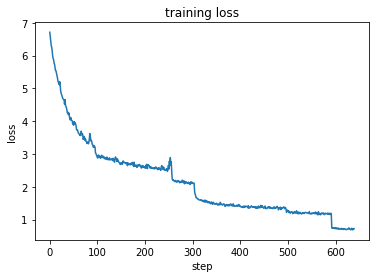

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
events_dict=get_events('nccl-eight-machines-ar')
events = events_dict['loss/loss']
plt.ylabel('loss')
plt.xlabel('step')
plt.title("training loss")
plt.plot(events.values())

## Get combined cost of evals

In [60]:
run = 'nccl-eight-machines-ar'
events_dict=get_events(run)
print(f"{sum(events_dict['time/eval_sec'].values())} seconds")

Parsing /efs/runs/nccl-eight-machines-ar/events.out.tfevents.1533052716.ip-192-168-35-231
80.45876622200012 seconds


# Housekeeping

## Clean-up logdirs

In [78]:
import os
def get_directory_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

for d in os.listdir('/efs/runs'):
  print(f"{get_directory_size(f'/efs/runs/{d}')}\t {d}")

1624400	 one-machines128-or
25	 ncclrev-eight-machines-ar
1708527	 pytorch-one-machines-ar.2018-07-30_19-07-31
956307	 nccl-two-machines-ar
303003	 ncclrev2-eight-machines-ar
25	 two-machines-or.2018-07-30_18-31-20
1155082	 one-machines192-or
956307	 pytorch-two-machines-ar
956307	 two-machines-or
20592	 pytorch-one-machines-ar
25	 pytorch-one-machines-ar.2018-07-30_19-06-19
302978	 nccl-eight-machines-ar
25	 one-machines-ar
416052	 four-machines-or
1708527	 one-machines-ar.2018-07-30_17-41-50


In [77]:
for d in os.listdir('/efs/runs'):
  logdir = f'/efs/runs/{d}'
  moved_logdir = f'/efs/runs.old/{d}'
  if get_directory_size(logdir) < 25 or 'test' in logdir or 'deleteme' in logdir:
    print(f"Moving {logdir} to {moved_logdir}")
    os.system(f'mv {logdir} {moved_logdir}')
  print(f"{get_directory_size(f'/efs/runs/{d}')}\t {d}")



1624400	 one-machines128-or
25	 ncclrev-eight-machines-ar
Moving /efs/runs/deleteme.2018-07-29_15-00-07 to /efs/runs.old/deleteme.2018-07-29_15-00-07
0	 deleteme.2018-07-29_15-00-07
Moving /efs/runs/deleteme.2018-07-29_17-05-00 to /efs/runs.old/deleteme.2018-07-29_17-05-00
0	 deleteme.2018-07-29_17-05-00
Moving /efs/runs/num-tasks-test to /efs/runs.old/num-tasks-test
0	 num-tasks-test
1708527	 pytorch-one-machines-ar.2018-07-30_19-07-31
Moving /efs/runs/pytorch-one-machines-ar.2018-07-30_19-04-34 to /efs/runs.old/pytorch-one-machines-ar.2018-07-30_19-04-34
0	 pytorch-one-machines-ar.2018-07-30_19-04-34
Moving /efs/runs/deleteme.2018-07-29_16-37-40 to /efs/runs.old/deleteme.2018-07-29_16-37-40
0	 deleteme.2018-07-29_16-37-40
Moving /efs/runs/deleteme.2018-07-29_16-33-26 to /efs/runs.old/deleteme.2018-07-29_16-33-26
0	 deleteme.2018-07-29_16-33-26
956307	 nccl-two-machines-ar
Moving /efs/runs/temp-image-rate-test to /efs/runs.old/temp-image-rate-test
0	 temp-image-rate-test
303003	 ncclr

# Scratch

In [63]:
!ls /efs/runs

another-test			    one-machines128-or
deleteme			    one-machines192-or
deleteme.2018-07-29_14-40-01	    one-machines-ar
deleteme.2018-07-29_15-00-07	    one-machines-ar.2018-07-30_17-41-50
deleteme.2018-07-29_16-24-50	    pytorch-one-machines-ar
deleteme.2018-07-29_16-27-48	    pytorch-one-machines-ar.2018-07-30_19-04-34
deleteme.2018-07-29_16-31-01	    pytorch-one-machines-ar.2018-07-30_19-05-49
deleteme.2018-07-29_16-33-26	    pytorch-one-machines-ar.2018-07-30_19-06-19
deleteme.2018-07-29_16-37-40	    pytorch-one-machines-ar.2018-07-30_19-07-31
deleteme.2018-07-29_17-05-00	    pytorch-two-machines-ar
deleteme.2018-07-29_17-13-11	    temp-image-rate-test
four-machines-or		    temp-image-rate-test.2018-07-30_11-00-42
nccl-eight-machines-ar		    temp-stop-test
ncclrev2-eight-machines-ar	    tmux-history-test
ncclrev-eight-machines-ar	    tmux-history-test.2018-07-31_15-27-50
nccl-two-machines-ar		    tmux-history-test.2018-07-31_15-33-37
new-test-run			    two-machines-or
num-tasks-te

1624400	 one-machines128-or
25	 ncclrev-eight-machines-ar
757926	 deleteme.2018-07-29_15-00-07
0	 deleteme.2018-07-29_17-05-00
0	 num-tasks-test
1708527	 pytorch-one-machines-ar.2018-07-30_19-07-31
0	 pytorch-one-machines-ar.2018-07-30_19-04-34
421442	 deleteme.2018-07-29_16-37-40
57830	 deleteme.2018-07-29_16-33-26
956307	 nccl-two-machines-ar
0	 temp-image-rate-test
303003	 ncclrev2-eight-machines-ar
25	 two-machines-or.2018-07-30_18-31-20
0	 tmux-history-test
677638	 temp-image-rate-test.2018-07-30_11-00-42
134207	 temp-stop-test
1708471	 another-test
1708471	 deleteme.2018-07-29_17-13-11
1155082	 one-machines192-or
157	 two-machine-test
1566184	 new-test-run
0	 tmux-history-test.2018-07-31_15-27-50
466	 deleteme.2018-07-29_16-24-50
1357948	 deleteme
956307	 pytorch-two-machines-ar
956307	 two-machines-or
20592	 pytorch-one-machines-ar
25	 pytorch-one-machines-ar.2018-07-30_19-06-19
102634	 deleteme.2018-07-29_14-40-01
302978	 nccl-eight-machines-ar
98865	 test-log-examples
375197	 

In [17]:
lines[0]

'Inter-|   Receive                                                |  Transmit'

In [18]:
lines[1]

' face |bytes    packets errs drop fifo frame compressed multicast|bytes    packets errs drop fifo colls carrier compressed'

In [19]:
lines[2]

'    lo: 4622682   19758    0    0    0     0          0         0  4622682   19758    0    0    0     0       0          0'

In [20]:
lines[3]

'  ens5: 409309874 1084540    0    0    0     0          0         0 577986838 1159118    0    0    0     0       0          0'

In [32]:
# Get in/out bytes from /proc/net/dev
def network_bytes():
import subprocess
proc = subprocess.Popen(['cat', '/proc/net/dev'], stdout=subprocess.PIPE)
stdout,stderr = proc.communicate()
stdout=stdout.decode('ascii')

recv_bytes = 0
transmit_bytes = 0
lines=stdout.strip().split('\n')
lines = lines[2:]  # strip header
for line in lines[2:]:
  line = line.strip()
  # ignore loopback interface
  if line.startswith('lo'):
    continue
  toks = line.split()

  recv_bytes += int(toks[1])
  transmit_bytes += int(toks[9])

ValueError: invalid literal for int() with base 10: 'Receive'

In [37]:
lines[1]

' face |bytes    packets errs drop fifo frame compressed multicast|bytes    packets errs drop fifo colls carrier compressed'

In [26]:
int(toks[9])

577986838

In [27]:
toks[0]

'ens5:'

In [30]:
recv_bytes

409309874

In [31]:
transmit_bytes

577986838